In [2]:
import os 
import warnings
import numpy as np
import pandas as pd 
import seaborn as sns
import shutil
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [3]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras import models
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image 
from skimage.io import imread
#import cv2

K.clear_session()

In [4]:
img = plt.imread('makanan/train/0_nasgor_1_jpg.rf.5cf6f5d045bcb4bbf63c2dcb4f6d92d3.jpg')
dims = np.shape(img)
matrix = np.reshape(img, (dims[0] * dims[1], dims[2]))
print(np.shape(matrix))

(173056, 3)


Image shape ->  (416, 416)
Color channels ->  3
Min color depth : 0, Max color depth 255


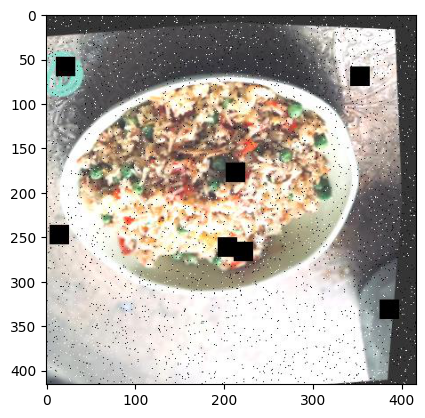

In [5]:
plt.imshow(img)
print("Image shape -> ",dims[:2])
print("Color channels -> ",dims[2])
print("Min color depth : {}, Max color depth {}".format(np.min(img),np.max(img)))

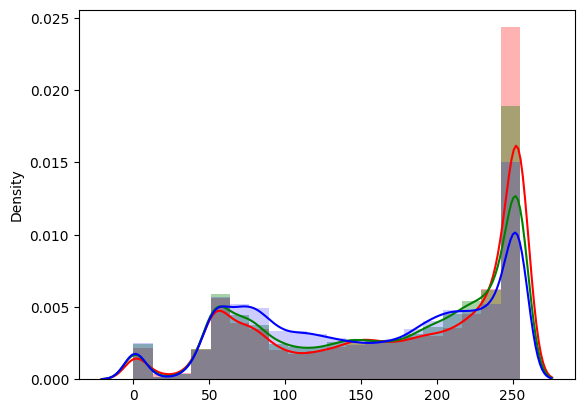

In [6]:
sns.distplot(matrix[:,0], bins=20,color="red",hist_kws=dict(alpha=0.3))
sns.distplot(matrix[:,1], bins=20,color="green",hist_kws=dict(alpha=0.35))
sns.distplot(matrix[:,2], bins=20,color="blue",hist_kws=dict(alpha=0.2))
plt.show()

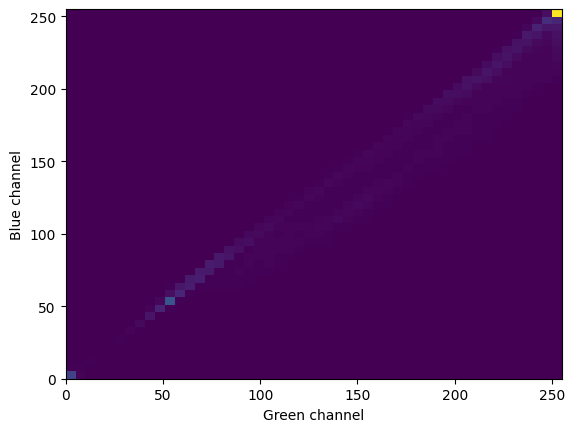

In [7]:
_ = plt.hist2d(matrix[:,1], matrix[:,2], bins=(50,50))
plt.xlabel('Green channel')
plt.ylabel('Blue channel')
plt.show()

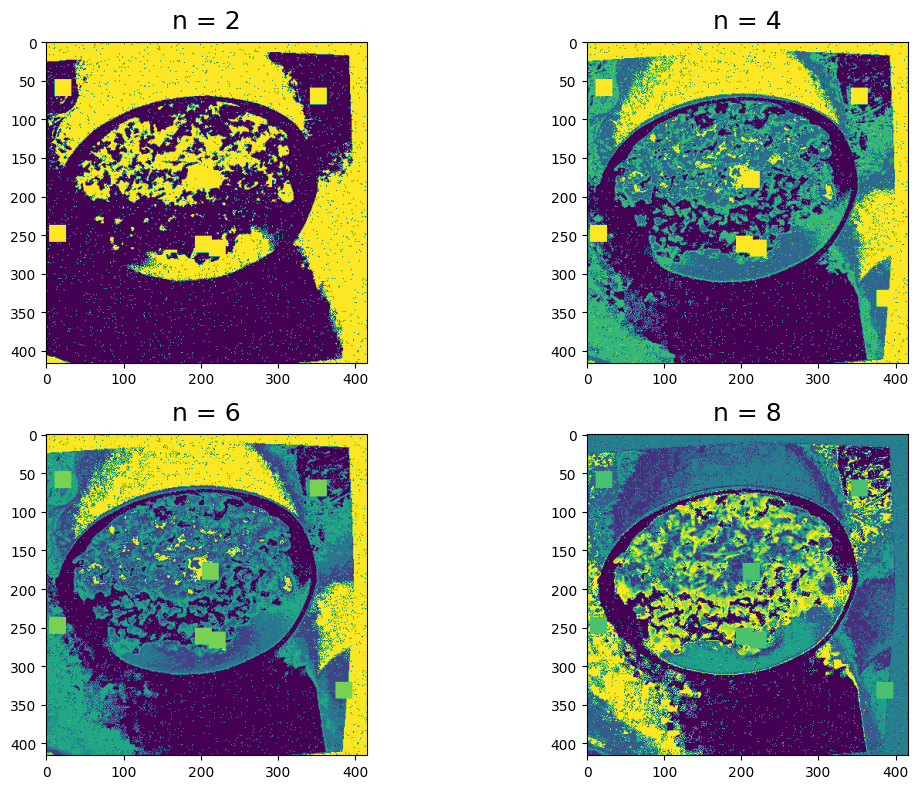

In [8]:
from sklearn import cluster
n_vals=[2,4,6,8]
plt.figure(1, figsize=(12, 8))

for subplot,n in enumerate(n_vals):
    kmeans=cluster.KMeans(n)
    clustered = kmeans.fit_predict(matrix)
    dims = np.shape(img)
    clustered_img = np.reshape(clustered, (dims[0], dims[1]))
    plt.subplot(2,2, subplot+1)
    plt.title("n = {}".format(n), pad = 10,size=18)
    plt.imshow(clustered_img)
    
plt.tight_layout()

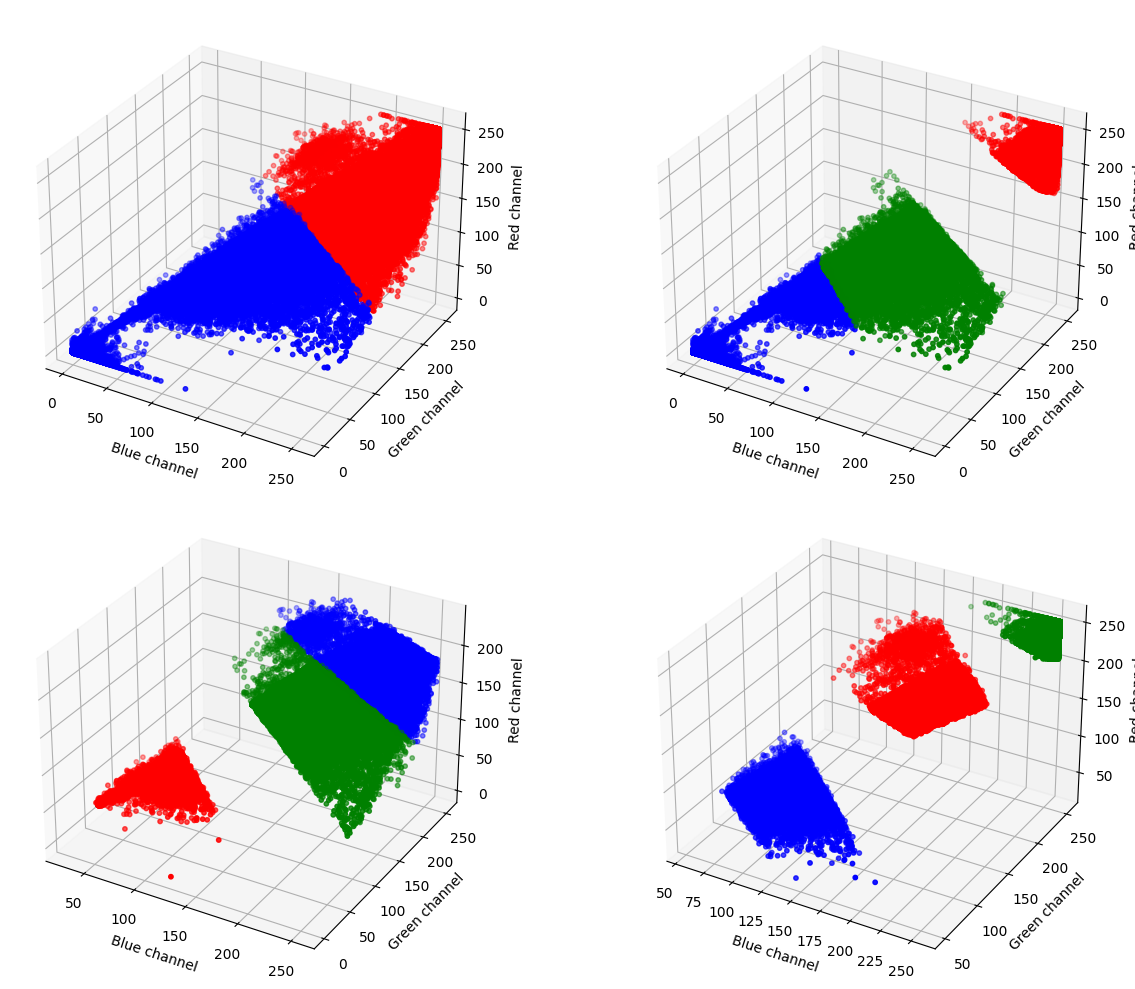

In [9]:
from mpl_toolkits.mplot3d import Axes3D

fig=plt.figure(figsize=(14,10))

ax = [fig.add_subplot(221, projection='3d'),
      fig.add_subplot(222, projection='3d'),
      fig.add_subplot(223, projection='3d'),
      fig.add_subplot(224, projection='3d')]

for plot_number,n in enumerate(n_vals):
    
    kmeans=cluster.KMeans(n)
    clustered = kmeans.fit_predict(matrix)
    x1, y1, z1 = [np.where(clustered == x)[0] for x in [0, 1, 2]]

    plot_vals = [('r', x1),
                 ('b', y1),
                 ('g', z1),
                 ]
    
    for c, channel in plot_vals:
        x = matrix[channel, 0]
        y = matrix[channel, 1]
        z = matrix[channel, 2]
        ax[plot_number].scatter(x, y, z, c=c,s=10)
    
    ax[plot_number].set_xlabel('Blue channel')
    ax[plot_number].set_ylabel('Green channel')
    ax[plot_number].set_zlabel('Red channel')

plt.tight_layout()

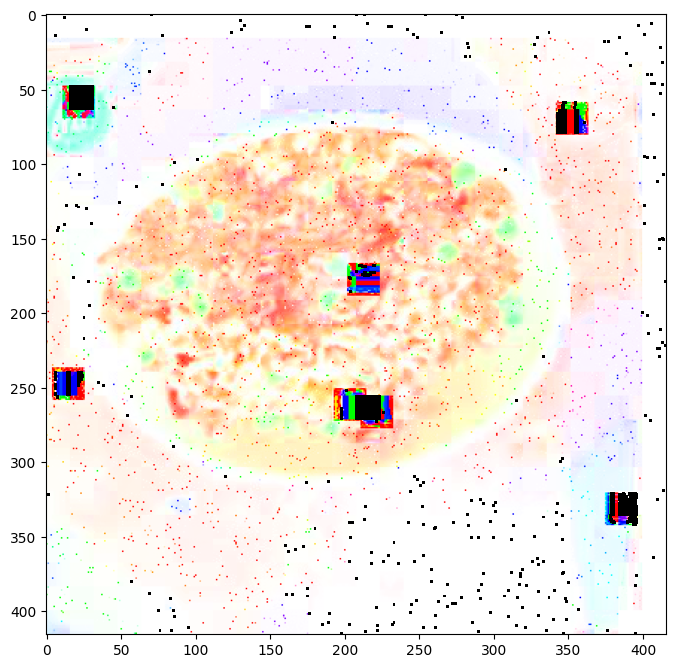

In [10]:
bnorm = np.zeros_like(matrix, dtype=np.float32)
max_range = np.max(matrix, axis=1)
bnorm = matrix / np.vstack((max_range, max_range, max_range)).T
bnorm_img = np.reshape(bnorm, (dims[0],dims[1],dims[2]))
plt.figure(figsize=(8,10))
plt.imshow(bnorm_img)
plt.show()

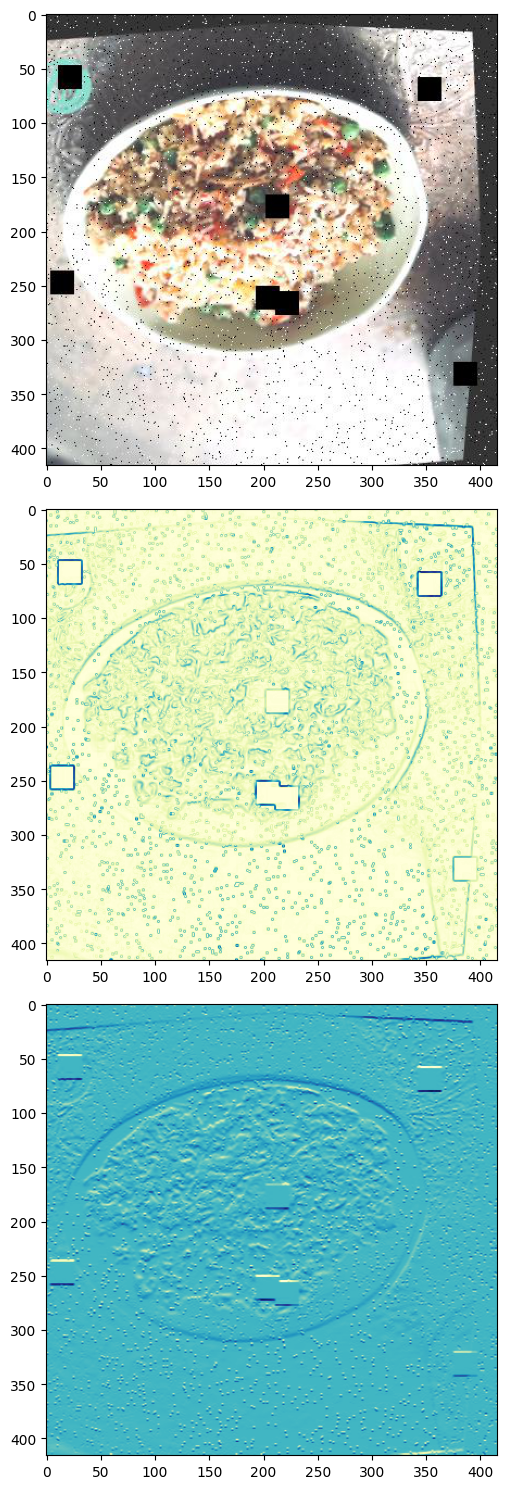

In [11]:
import skimage
from skimage.feature import greycomatrix, greycoprops
from skimage.filters import sobel
from skimage.filters import sobel_h

plt.figure(1,figsize=(20,15))
cmap="YlGnBu"
plt.subplot(3,1,1)
plt.imshow(img)

plt.subplot(3,1,2)
plt.imshow(sobel(img[:,:,2]),cmap=cmap)

plt.subplot(3,1,3)
plt.imshow(sobel_h(img[:,:,1]), cmap=cmap)

plt.tight_layout()

In [12]:
dataset_path = "makanan/train"
# Counters for images with non-416x416 size and total images
non_416_count = 0
total_count = 0

# Iterate over the images in the dataset
for filename in os.listdir(dataset_path):
    if filename.endswith('.jpg'):
        image_path = os.path.join(dataset_path, filename)
        
        # Open the image
        image = Image.open(image_path)
        
        # Get the image size
        width, height = image.size
        
        # Check if the size is not 416x416
        if width != 416 or height != 416:
            non_416_count += 1
        
        total_count += 1

print(f"Total images: {total_count}")
print(f"Images with non-416x416 size: {non_416_count}")
print(f"Images with 416x416 size: {total_count - non_416_count}")

Total images: 4368
Images with non-416x416 size: 0
Images with 416x416 size: 4368


In [13]:
n_classes = 11
batch_size = 32
img_width, img_height = 256, 256
train_data_dir = 'makanan/train'

# Create temporary directories to organize the data
temp_train_dir = 'makanan/temp_train'
os.makedirs(temp_train_dir, exist_ok=True)

# Iterate over the files in the train directory
for filename in os.listdir(train_data_dir):
    if filename.endswith('.jpg'):
        # Extract the class label from the filename
        class_label = filename.split('_')[1]
        
        # Create a subfolder for the class if it doesn't exist
        class_dir = os.path.join(temp_train_dir, class_label)
        os.makedirs(class_dir, exist_ok=True)
        
        # Move the file to the respective class subfolder
        src_path = os.path.join(train_data_dir, filename)
        dest_path = os.path.join(class_dir, filename)
        shutil.copy(src_path, dest_path)

#ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    temp_train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

# Delete the temporary train directory
#shutil.rmtree(temp_train_dir)

Found 4368 images belonging to 11 classes.


In [14]:
val_data_dir = 'makanan/test'

# Create temporary directories to organize the data
temp_val_dir = 'makanan/temp_val'
os.makedirs(temp_train_dir, exist_ok=True)

# Iterate over the files in the train directory
for filename in os.listdir(val_data_dir):
    if filename.endswith('.jpg'):
        # Extract the class label from the filename
        class_label = filename.split('_')[1]
        
        # Create a subfolder for the class if it doesn't exist
        class_dir = os.path.join(temp_val_dir, class_label)
        os.makedirs(class_dir, exist_ok=True)
        
        # Move the file to the respective class subfolder
        src_path = os.path.join(val_data_dir, filename)
        dest_path = os.path.join(class_dir, filename)
        shutil.copy(src_path, dest_path)

#ImageDataGenerator
val_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_generator = train_datagen.flow_from_directory(
    temp_val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

# Delete the temporary train directory
#shutil.rmtree(temp_train_dir)

Found 625 images belonging to 11 classes.


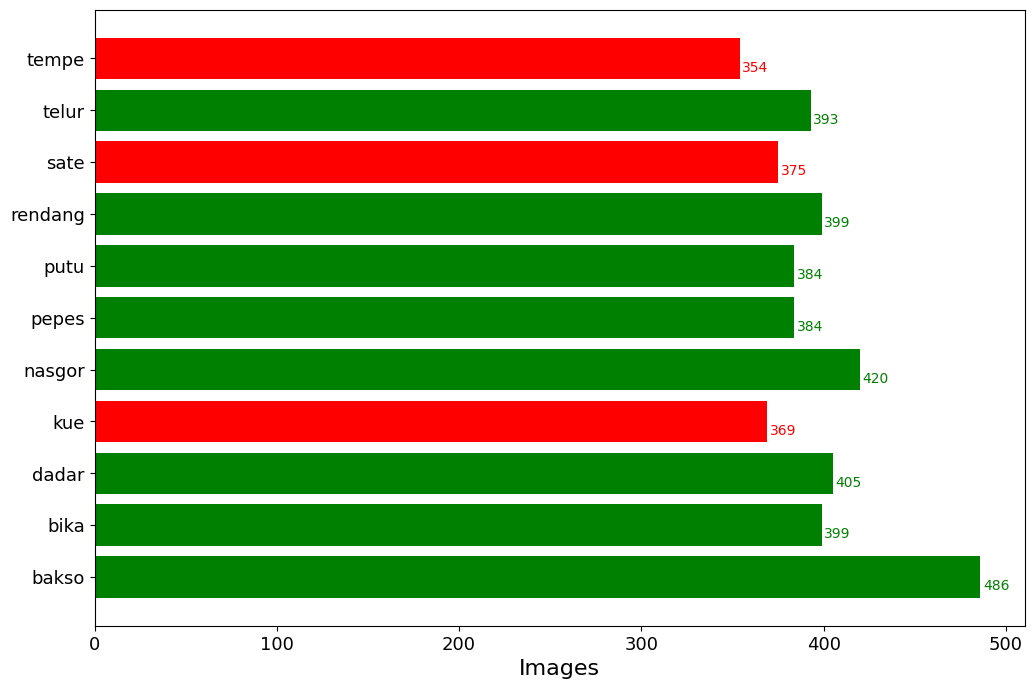

In [15]:
main='makanan/temp_train/'

data=dict()

for i in os.listdir(main):
    sub_dir=os.path.join(main,i)
    count=len(os.listdir(sub_dir))
    data[i]=count
    
  
keys = data.keys()
values = data.values()

colors=["red" if x<= 375 else "green" for x in values]

fig, ax = plt.subplots(figsize=(12,8))
y_pos=np.arange(len(values))
plt.barh(y_pos,values,align='center',color=colors)
for i, v in enumerate(values):
    ax.text(v+1.4, i-0.25, str(v), color=colors[i])
ax.set_yticks(y_pos)
ax.set_yticklabels(keys)
ax.set_xlabel('Images',fontsize=16)
plt.xticks(color='black',fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [16]:
model = tf.keras.Sequential([
  #tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(img_height, img_width, 3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),


  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(n_classes, activation='softmax')
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [19]:
history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
137/137 [==============================] - 259s 2s/step - loss: 1.9673 - accuracy: 0.2853 - val_loss: 1.5919 - val_accuracy: 0.4272
Epoch 2/10
137/137 [==============================] - 189s 1s/step - loss: 1.5748 - accuracy: 0.4400 - val_loss: 1.4172 - val_accuracy: 0.4896
Epoch 3/10
137/137 [==============================] - 200s 1s/step - loss: 1.4725 - accuracy: 0.4746 - val_loss: 1.3893 - val_accuracy: 0.4880
Epoch 4/10
137/137 [==============================] - 189s 1s/step - loss: 1.3267 - accuracy: 0.5309 - val_loss: 1.2554 - val_accuracy: 0.5712
Epoch 5/10
137/137 [==============================] - 192s 1s/step - loss: 1.2846 - accuracy: 0.5442 - val_loss: 1.1560 - val_accuracy: 0.5872
Epoch 6/10
137/137 [==============================] - 200s 1s/step - loss: 1.1812 - accuracy: 0.5723 - val_loss: 1.1368 - val_accuracy: 0.5808
Epoch 7/10
137/137 [==============================] - 193s 1s/step - loss: 1.1024 - accuracy: 0.6115 - val_loss: 1.0574 - val_accuracy: 0.6368

In [21]:
history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
137/137 [==============================] - 200s 1s/step - loss: 0.8509 - accuracy: 0.6948 - val_loss: 1.0648 - val_accuracy: 0.6416
Epoch 2/10
137/137 [==============================] - 197s 1s/step - loss: 0.8109 - accuracy: 0.7099 - val_loss: 1.1914 - val_accuracy: 0.6240
Epoch 3/10
137/137 [==============================] - 193s 1s/step - loss: 0.8036 - accuracy: 0.7104 - val_loss: 0.9521 - val_accuracy: 0.6944
Epoch 4/10
137/137 [==============================] - 191s 1s/step - loss: 0.7436 - accuracy: 0.7386 - val_loss: 1.0144 - val_accuracy: 0.6816
Epoch 5/10
137/137 [==============================] - 195s 1s/step - loss: 0.6904 - accuracy: 0.7596 - val_loss: 0.9032 - val_accuracy: 0.6928
Epoch 6/10
137/137 [==============================] - 190s 1s/step - loss: 0.6704 - accuracy: 0.7614 - val_loss: 1.0347 - val_accuracy: 0.6912
Epoch 7/10
137/137 [==============================] - 195s 1s/step - loss: 0.6463 - accuracy: 0.7672 - val_loss: 0.9925 - val_accuracy: 0.6928

In [22]:
history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
137/137 [==============================] - 195s 1s/step - loss: 0.4966 - accuracy: 0.8205 - val_loss: 1.1046 - val_accuracy: 0.7072
Epoch 2/10
137/137 [==============================] - 215s 2s/step - loss: 0.5260 - accuracy: 0.8098 - val_loss: 1.1812 - val_accuracy: 0.6960
Epoch 3/10
137/137 [==============================] - 239s 2s/step - loss: 0.4586 - accuracy: 0.8354 - val_loss: 0.9715 - val_accuracy: 0.7248
Epoch 4/10
137/137 [==============================] - 207s 2s/step - loss: 0.4391 - accuracy: 0.8475 - val_loss: 0.9676 - val_accuracy: 0.7120
Epoch 5/10
137/137 [==============================] - 201s 1s/step - loss: 0.4127 - accuracy: 0.8578 - val_loss: 1.0692 - val_accuracy: 0.7360
Epoch 6/10
137/137 [==============================] - 206s 2s/step - loss: 0.4250 - accuracy: 0.8450 - val_loss: 0.9752 - val_accuracy: 0.7232
Epoch 7/10
137/137 [==============================] - 236s 2s/step - loss: 0.3985 - accuracy: 0.8585 - val_loss: 1.0899 - val_accuracy: 0.7264

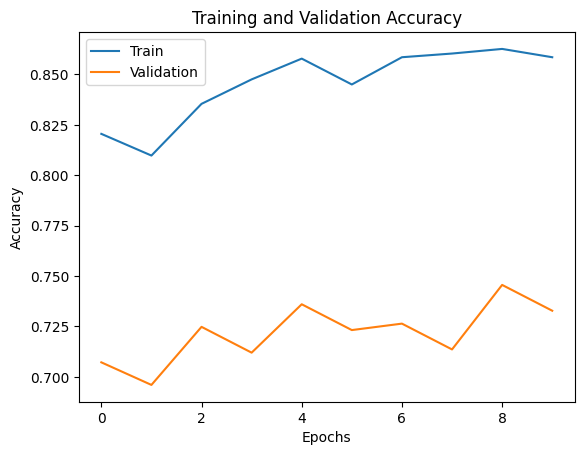

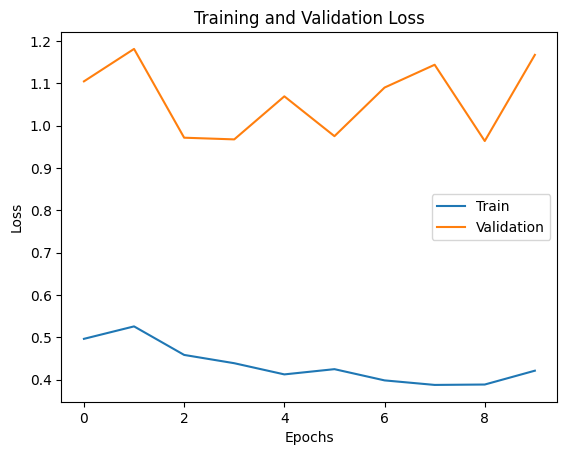

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [25]:
class_indices = train_generator.class_indices

# Print class names and indices
for class_name, index in class_indices.items():
    print("Class:", class_name)
    print("Index:", index)


Class: bakso
Index: 0
Class: bika
Index: 1
Class: dadar
Index: 2
Class: kue
Index: 3
Class: nasgor
Index: 4
Class: pepes
Index: 5
Class: putu
Index: 6
Class: rendang
Index: 7
Class: sate
Index: 8
Class: telur
Index: 9
Class: tempe
Index: 10


In [37]:
# Load the image
image_path = 'st.jpg'
image = Image.open(image_path)

# Preprocess the image
image = image.resize((img_width, img_height))  # Resize the image to match the input size of the model
image = np.array(image)  # Convert the image to a NumPy array
image = image / 255.0  # Normalize the pixel values (assuming your model was trained with normalization)

# Reshape the image to match the expected input shape of the model
image = np.reshape(image, (1, img_width, img_height, 3))  # Adjust the shape according to your model's input shape

# Make predictions
predictions = model.predict(image)
predicted_class = np.argmax(predictions)  # Get the index of the predicted class

# Print the predicted class and its probability
print("Predicted class:", predicted_class)
print("Probability:", predictions[0, predicted_class])


1/1 [==============================] - 0s 40ms/step
Predicted class: 8
Probability: 0.8195836
